C:\ProgramData\Anaconda3\lib\site-packages\yfinance\base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


Monte Carlo simulation for NVDA in 2024, going up to 03/11/24.
Simulating 48 days of real returns.
***********  2023 STATISTICS  ***************
Log Return Drift (Mean Daily Return): 0.0049861561688848656
Log Return Variance (Mean Daily Standard Deviation): 0.029477154773435522

Annualized Average Log Return: 1.2415528860523315
Annualized Standard Deviation of Log Returns: 0.4651416566280976


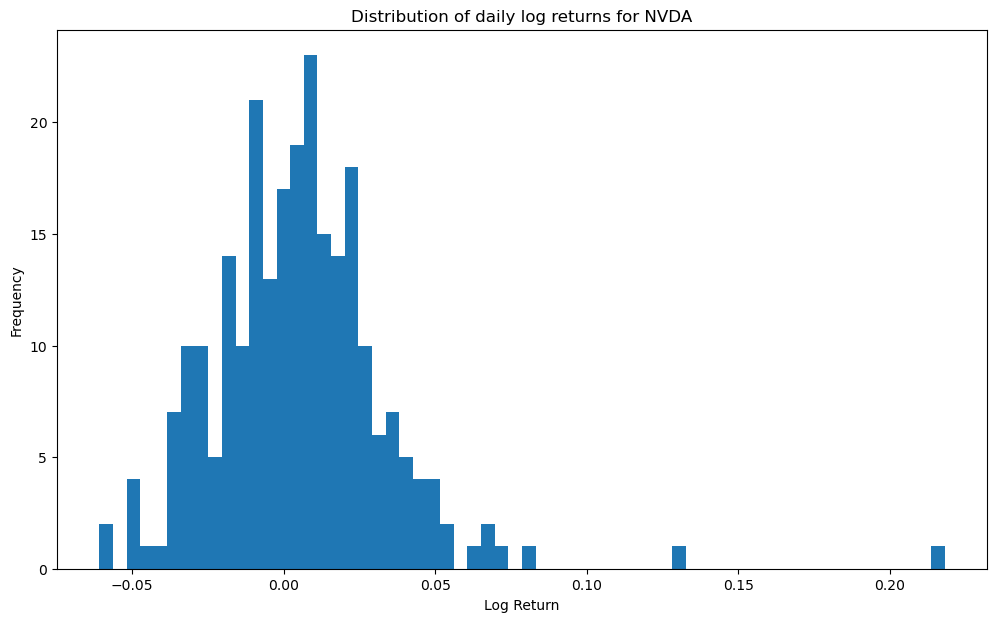

KS Statistic: 0.06870539334594161
P-value: 0.18184866652203502
The data follows a normal distribution (fail to reject H0).
***********  2024 MONTE CARLO SIMULATION STATISTICS  ***************


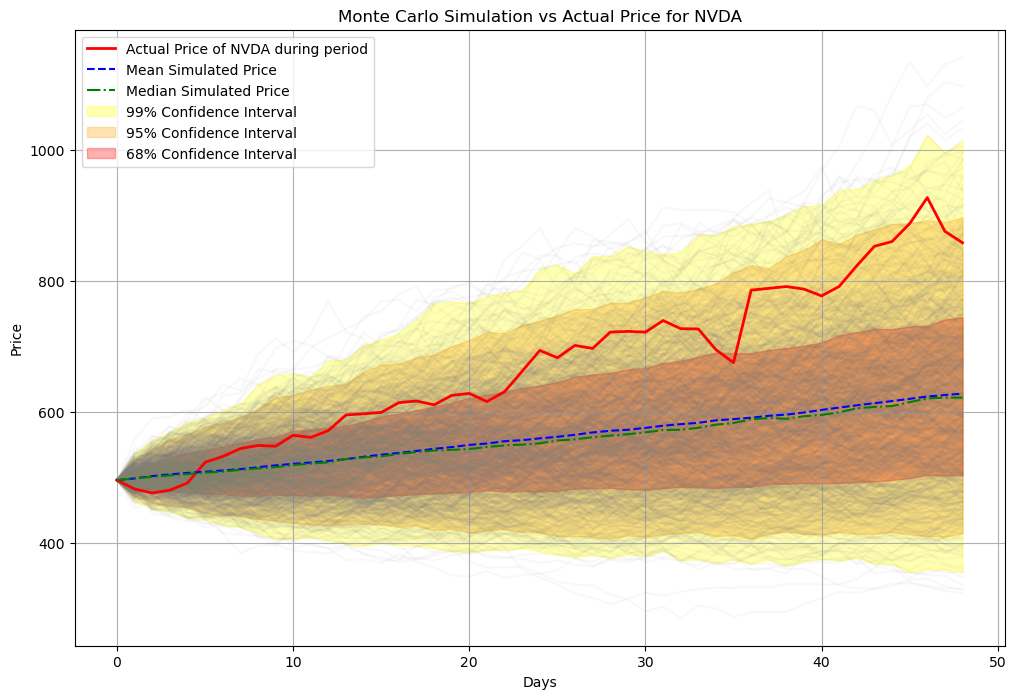

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats, optimize
import numpy as np
from scipy.stats import t

np.random.seed(42)  ## for reproducible results

## Basic workflow to use:
## 1. Test price data to ensure returns are lognormal; if not, model Monte Carlo simulation as draws from t distribution instead.
## 2. Estimate parameters for Monte Carlo Simulation from returns on train period (we can use last year, 2023)
## 3. Run simulation for extended number of trials over variety of frequencies; report and plot result over a test period

## Helper function, to estimate t distribution degrees of freedom    
## Define the negative log likelihood function for the t-distribution, tested for a given degree of freedom (df)
def neg_log_likelihood(df, data, drift, sigma):
    # We will take our mean and std as the empirical values from the provided data
    return -np.sum(t.logpdf(data, df, drift, sigma))

## One Company Workflow. Test period is YTD returns.

test_ticker = 'NVDA'
train_data_start_date = '2023-01-01'
train_data_end_date = '2024-01-01'
test_data_start_date = '2024-01-01'
test_data_end_date = '2025-01-01'

data = yf.Ticker(test_ticker).history(start=train_data_start_date, 
                                      end=train_data_end_date)
daily_log_ret = (np.log(data['Close']) - np.log(data['Close'].shift(1))).dropna()

## This is the 2024 YTD data we are aiming to simulate
test_data = yf.Ticker(test_ticker).history(start=test_data_start_date,
                                           end=test_data_end_date)
actual_prices = test_data['Close']

if len(test_data) > 0:
    print(f"Monte Carlo simulation for {test_ticker} in 2024, going up to {test_data.index[-1].strftime('%D')}.")
    print(f"Simulating {len(test_data)} days of real returns.")

print("***********  2023 STATISTICS  ***************")

## Perform the one-sample K-S test for normal distribution with empirical parameters
mu = daily_log_ret.mean()  # Estimated daily mean of log returns
sigma = daily_log_ret.std()  # Estimated daily standard deviation of log returns
drift = mu - sigma ** 2 / 2 ## Estimated Brownian Motion drift
ks_statistic, p_value = stats.kstest(daily_log_ret, 'norm', args=(drift, sigma))

## Print the results
print(f'Log Return Drift (Mean Daily Return): {daily_log_ret.mean()}')
print(f'Log Return Variance (Mean Daily Standard Deviation): {daily_log_ret.std()}\n')

## Number of trading days of return we are calculating from
trading_days = len(daily_log_ret)

## Print the annualized figures
print(f"Annualized Average Log Return: {daily_log_ret.mean() * trading_days}")
print(f"Annualized Standard Deviation of Log Returns: {daily_log_ret.std() * np.sqrt(trading_days)}")

plt.figure(figsize=(12,7))
plt.hist(daily_log_ret, bins=int(len(daily_log_ret)/4))
plt.title(f"Distribution of daily log returns for {test_ticker}")
plt.xlabel('Log Return')
plt.ylabel('Frequency')
plt.show()

print(f'KS Statistic: {ks_statistic}')
print(f'P-value: {p_value}')

## Interpret the results
alpha = 0.05  # Significance level for normality assumption
if p_value < alpha:
    print("The data is not normally distributed (reject H0).")
    
    ## We now want to estimate the degrees of freedom for the t-distribution to be drawn from
    ## in the simulation. For this t-distribution, we will assume the mean and standard deviation
    ## is the empirically observed variants.

    ## Initial guess for df degrees of freedom
    initial_guess = 10

    ## Optimize the negative log likelihood function
    result = optimize.minimize(neg_log_likelihood, initial_guess, args=(daily_log_ret,drift,sigma), bounds=[(1, 300)])

    ## Extract the estimated DF
    estimated_df = result.x[0]

    print(f"Estimated degrees of freedom for a t-distribution: {estimated_df}")
else:
    print("The data follows a normal distribution (fail to reject H0).")
    
print("***********  2024 MONTE CARLO SIMULATION STATISTICS  ***************")

## Parameters for Monte Carlo Simulation
S0 = data['Close'][-1]         ## Initial stock price
T = len(test_data)           # Timeframe in days (i.e. # of trading days so far in the year)
#T = 10
mu = daily_log_ret.mean()  # Estimated daily mean of log returns
sigma = daily_log_ret.std()  # Estimated daily standard deviation of log returns
drift = mu - sigma ** 2 / 2 # Estimated Brownian Motion drift
simulations = 1000  # Number of Monte Carlo simulations

## Monte Carlo Simulation of Log Returns
if p_value < alpha: ## Data is not normally distributed
    log_returns = t.rvs(estimated_df, loc=drift, scale=sigma, size=(T, simulations))
else:
    log_returns = np.random.normal(drift, sigma, (T, simulations))

## Adding the 0th day to show progression from 2023 year-end price    
day_0 = np.zeros((1, simulations))
log_returns = np.vstack((day_0,log_returns))    
    
stock_prices = S0 * np.exp(np.cumsum(log_returns, axis=0))  ## Cumulative sum log returns to simulate paths

## Calculate statistics from the simulated paths
mean_prices = np.mean(stock_prices, axis=1)
median_prices = np.median(stock_prices, axis=1)
onesigma_lower_bound = np.percentile(stock_prices, 16.0, axis=1)
onesigma_upper_bound = np.percentile(stock_prices, 84.0, axis=1)
twosigma_lower_bound = np.percentile(stock_prices, 2.5, axis=1)
twosigma_upper_bound = np.percentile(stock_prices, 97.5, axis=1)
threesigma_lower_bound = np.percentile(stock_prices, 0.5, axis=1)
threesigma_upper_bound = np.percentile(stock_prices, 99.5, axis=1)

## Plotting the simulated paths and the actual path in comparison
plt.figure(figsize=(12,8))
plt.plot(stock_prices, color='gray', alpha=0.05)  ## Simulated prices, faded
plt.plot([S0] + list(actual_prices), label=f'Actual Price of {test_ticker} during period', 
         linewidth=2, color='red')  ## Actual prices

## Plot the statistics
plt.plot(mean_prices, label='Mean Simulated Price', linestyle='--', color='blue')
plt.plot(median_prices, label='Median Simulated Price', linestyle='-.', color='green')
plt.fill_between(range(T+1), threesigma_lower_bound, threesigma_upper_bound, color='yellow', alpha=0.3, 
                 label='99% Confidence Interval')
plt.fill_between(range(T+1), twosigma_lower_bound, twosigma_upper_bound, color='orange', alpha=0.3, 
                 label='95% Confidence Interval')
plt.fill_between(range(T+1), onesigma_lower_bound, onesigma_upper_bound, color='red', alpha=0.3, 
                 label='68% Confidence Interval')

plt.title(f'Monte Carlo Simulation vs Actual Price for {test_ticker}')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

In [3]:
## Ideas for next steps:
## 1. Build interface for entering tickers, modes of prediction (testing, or prediction into the future)
## 2. More robust estimation of simulation parameters: i.e. estimation of drift term, volatility term
## 2*. For drift, research methods, potentially incorporate risk factors and interest rates
## 2**. For volatility, research these methods as well, gather historical options implied volatility, other ways to estimate vol
## such as GARCH, RiskMetrics
## 3. Use the Monte Carlo simulations for downstream tasks, e.g. Option Pricing
## 4. Consider simulating volatility as well with its own Brownian motion

In [2]:
## Widget/GUI Code=
import ipywidgets as widgets
from IPython.display import display, clear_output
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
import yfinance as yf
import pandas as pd
from scipy import stats, optimize

# Function to perform iterative Monte Carlo Simulation
## Can be used for stochastic volatility estimates, using simplified Brownian motion based on Heston model
def monte_carlo_simulation(stock_price, days, mu, sigma, vol_of_vol, rho, simulations, 
                           return_distribution="normal", stochastic_vol=False, estimated_df=10):
    dt = 1 # Assume daily simulation
    price_paths = np.zeros((days+1, simulations)) ## Array for storing price history
    vol_paths = np.zeros((days+1, simulations)) ## Array for storing daily (stochastic) volatilities 
    price_paths[0] = stock_price
    vol_paths[0] = sigma

    for idx in range(1, days+1):
        ## Drawing stock price random variable from input distribution 
        if return_distribution == "normal":
            z1 = np.random.normal(size=simulations)
        else:
            z1 = t.rvs(estimated_df, size=simulations)
        ## Drawing volatility random variable from normal distribution, correlated by input rho with stock price shocks
        z2 = rho * z1 + np.sqrt(1 - rho**2) * np.random.normal(size=simulations)  ## Correlated random variables
        if stochastic_vol:
            ## Simulating stochastic volatility as a Brownian motion with 0 drift.
            vol_paths[idx] = vol_paths[idx - 1] * np.exp(vol_of_vol * np.sqrt(dt) * z2 - 0.5 * vol_of_vol**2 * dt)
        else:
            vol_paths[idx] = vol_paths[idx - 1]
            
        # Stock price is affected by z1, ensuring correlation with volatility
        price_paths[idx] = price_paths[idx - 1] * np.exp((mu - 0.5 * vol_paths[idx - 1] ** 2) 
                                                     * dt + vol_paths[idx - 1] * np.sqrt(dt) * z1)
    return price_paths, vol_paths

# Function to fetch historical stock data and calculate mu and sigma
def fetch_stock_data(ticker, period="1y"):
    stock_data = yf.download(ticker, period=period)
    stock_price = stock_data['Adj Close'][-1]
    daily_returns = np.log(stock_data['Adj Close'] / stock_data['Adj Close'].shift(1)).dropna()
    
    # Calculate 30 day volatilities (standard deviation of returns)
    daily_volatilities = daily_returns.rolling(window=30).std().dropna()
    # Estimate the volatility of these volatilities (vol of vol)
    vol_of_vol = daily_volatilities.std()
    print(f"Volatility of Volatility: {vol_of_vol}")
    return stock_price, daily_returns, vol_of_vol, daily_volatilities

# GUI components
simulation_type = widgets.Dropdown(
    options=['Select Simulation Type', 'Real Stock', 'Input Parameters'],
    value='Select Simulation Type',
    description='Simulation:',
    disabled=False,
)

stock_ticker = widgets.Text(value='', description='Ticker:', disabled=False)
historical_range = widgets.Dropdown(options=['1mo', '3mo', '6mo', '1y', '2y', '5y'], value='1y', 
                                    description='Hist. Data Range:', disabled=False, style={'description_width': 'initial'})
normality_test = widgets.Dropdown(options=[True, False], value=True, 
                                    description='Test Rtn. Normality?:', disabled=False, style={'description_width': 'initial'})
stochastic_volatility = widgets.Dropdown(
    options=[False, True], value=False, description='Stochastic Volatility Simulation:',disabled=False, 
    style={'description_width': 'initial'}
)

## Input parameter fields for hypothetical stocks
stock_input = widgets.FloatText(value=100, description='Stock Price:', disabled=False)
days_input = widgets.IntText(value=252, description='Days:', disabled=False)
parameter_type = widgets.Dropdown(
    options=['Select Parameter Type', 'Daily', 'Annualized'],
    value='Select Parameter Type',
    description='Param. Type:',
    disabled=False,
)
mu_input = widgets.FloatText(value=0.002, description='Drift (mu):', disabled=False)
sigma_input = widgets.FloatText(value=0.02, description='Volatility (sigma):', disabled=False,
                                style={'description_width': 'initial'})
# Widgets for the stochastic volatility parameters
rho_input = widgets.FloatText(value=-0.05, description='Corr. btwn Px chg. and Vol. chg.:', 
                              style={'description_width': 'initial'}, disabled=False)
vol_of_vol_input = widgets.FloatText(value=0.005, description='Vol of Volatility:', 
                                     style={'description_width': 'initial'}, disabled=False)

simulation_input = widgets.IntText(value=10000, description='#Simulations:', disabled=False, 
                                   style={'description_width': 'initial'})
simulate_button = widgets.Button(description="Simulate", disabled=True)

# Container for the dynamic GUI components
dynamic_container = widgets.VBox([])

# Output widget for the simulation results
output = widgets.Output()

simulated_price_archive = None # Storing the simulated prices for further archiving once finished

# Function to update GUI based on simulation type
def on_simulation_type_change(change):
    if change['new'] == 'Real Stock':
        dynamic_container.children = [simulation_input, days_input, stock_ticker, historical_range, 
                                      normality_test, stochastic_volatility, simulate_button]
        simulate_button.disabled = False  # Enable the button when 'Real Stock' is selected
    elif change['new'] == 'Input Parameters':
        dynamic_container.children = [simulation_input, days_input, stock_input, parameter_type, 
                                      mu_input, sigma_input, stochastic_volatility, simulate_button]
        if stochastic_volatility.value:
            dynamic_container.children = [simulation_input, days_input, stock_input, parameter_type,
                                          mu_input, sigma_input, stochastic_volatility, rho_input, 
                                          vol_of_vol_input, simulate_button]
        check_parameter_type()  # Check parameter type to decide whether to enable the simulate button
    else:
        dynamic_container.children = []
    return

def check_stochastic_volatility_change(change):
    sim_type = {'new': simulation_type.value}
    on_simulation_type_change(sim_type)
    return
 
# Function to check parameter type and enable/disable simulate button

def check_parameter_type():
    simulate_button.disabled = False if parameter_type.value in ['Daily', 'Annualized'] else True
    return

# Function to convert annualized parameters to daily if needed
def convert_parameters(mu, sigma, param_type):
    if param_type == 'Annualized':
        # Convert annualized parameters to daily
        mu = mu / 252
        sigma = sigma / np.sqrt(252)
    return mu, sigma

# Simulation function on button click
def on_simulate_clicked(b):
    with output:
        clear_output()
        days = days_input.value
        stochastic_vol = stochastic_volatility.value
        log_return_dist = 'normal'
        
        n_simulations = simulation_input.value
        if simulation_type.value == 'Real Stock':
            ticker = stock_ticker.value.upper()
            period = historical_range.value
            stock_price, returns, vol_of_vol, daily_volatilities = fetch_stock_data(ticker, period)
            mu = returns.mean()  # Estimated daily mean of log returns
            sigma = returns.std()  # Estimated daily standard deviation of log returns
            drift = mu - sigma ** 2 / 2 ## Brownian Motion drift
            rho = np.corrcoef(returns[-len(daily_volatilities)+1:], 
                              daily_volatilities[:-1])[0, 1]  # Correlation between returns and volatility changes
            df = 0 ## Placeholder value
            print(f"Rho: {rho}")
            if normality_test.value == True:
                ## Perform the one-sample K-S test for normal distribution with empirical parameters
                ks_statistic, p_value = stats.kstest(returns, 'norm', args=(mu, sigma))
                plt.figure(figsize=(12,5))
                plt.hist(returns, bins=int(len(returns)/4))
                plt.title(f"Distribution of daily log returns for {ticker}")
                plt.xlabel('Log Return')
                plt.ylabel('Frequency')
                plt.show()

                print(f'KS Statistic: {ks_statistic}')
                print(f'P-value: {p_value}')

                ## Interpret the results
                alpha = 0.05  # Significance level for normality assumption
                if p_value < alpha:
                    print(f"The return data is not normally distributed (reject H0). Significance level: {1-alpha:.1%}")
                    log_return_dist = "t"
                    df, mu, sigma = t.fit(returns)
                    print("T-Distribution Estimate:")
                    print(f"Degrees of freedom: {df}, Drift: {mu}, Sigma: {sigma}")
                else:
                    print(f"Cannot reject the null hypothesis of lognormal returns (fail to reject H0). Significance level: {1-alpha:.1%}")
                    print(f"Distribution Mu: {mu}, Drift: {drift}, Sigma: {sigma}")
                
        else:
            stock_price = stock_input.value
            mu = mu_input.value
            sigma = sigma_input.value
            mu, sigma = convert_parameters(mu, sigma, parameter_type.value)
            drift = mu - sigma ** 2 / 2 ## Brownian Motion Drift
            df = 0
            if stochastic_vol:
                rho = rho_input.value
                vol_of_vol = vol_of_vol_input.value
            else:
                rho, vol_of_vol = 0, 0
        
        ## Monte Carlo Simulation of Log Returns
        simulated_prices, volatility_paths = monte_carlo_simulation(stock_price, days, mu, sigma, vol_of_vol, rho, n_simulations,
                                                                    return_distribution=log_return_dist,
                                                                    stochastic_vol=stochastic_vol, estimated_df=df)
        
        ## Calculate statistics from the simulated paths
        mean_prices = np.mean(simulated_prices, axis=1)
        median_prices = np.median(simulated_prices, axis=1)
        onesigma_lower_bound = np.percentile(simulated_prices, 16.0, axis=1)
        onesigma_upper_bound = np.percentile(simulated_prices, 84.0, axis=1)
        twosigma_lower_bound = np.percentile(simulated_prices, 2.5, axis=1)
        twosigma_upper_bound = np.percentile(simulated_prices, 97.5, axis=1)
        threesigma_lower_bound = np.percentile(simulated_prices, 0.5, axis=1)
        threesigma_upper_bound = np.percentile(simulated_prices, 99.5, axis=1)

        ## Plotting the simulated paths and the actual path in comparison
        plt.figure(figsize=(12,6))
        plt.plot(simulated_prices, color='gray', alpha=0.05 * (1000 / n_simulations))  ## Simulated prices, faded
        # plt.plot([S0] + list(actual_prices), label=f'Actual Price of {test_ticker} during period', 
        #          linewidth=2, color='red')  ## Actual prices

        ## Plot the statistics
        plt.plot(mean_prices, label='Mean Simulated Price', linestyle='--', color='blue')
        plt.plot(median_prices, label='Median Simulated Price', linestyle='-.', color='green')
        plt.fill_between(range(days+1), threesigma_lower_bound, threesigma_upper_bound, color='yellow', alpha=0.3, 
                         label='99% Confidence Interval')
        plt.fill_between(range(days+1), twosigma_lower_bound, twosigma_upper_bound, color='orange', alpha=0.3, 
                         label='95% Confidence Interval')
        plt.fill_between(range(days+1), onesigma_lower_bound, onesigma_upper_bound, color='red', alpha=0.3, 
                         label='68% Confidence Interval')
        
        ticker_name = ticker if simulation_type.value == 'Real Stock' else 'Hypothetical Stock'
        plt.title(f'Monte Carlo Simulation of Stock Prices for {ticker_name}')
        plt.xlabel('Days')
        plt.ylabel('Price')
        plt.legend()
        plt.show()
        
        ## Plot histogram of final day prices 
        plt.figure(figsize=(12,6))
        plt.hist(simulated_prices[-1, :], bins=int(n_simulations / 20))
        plt.title(f"Distribution of simulated prices on final day, Day {days}")
        plt.xlabel(f"{ticker_name} Price")
        plt.ylabel("Frequency")
        plt.show()
        
        global simulated_price_archive
        simulated_price_archive = simulated_prices

# Link components to functions
stochastic_volatility.observe(check_stochastic_volatility_change, names='value')
simulation_type.observe(on_simulation_type_change, names='value')
parameter_type.observe(lambda change: check_parameter_type(), names='value')
simulate_button.on_click(on_simulate_clicked)

In [3]:
# Display GUI components
display(simulation_type, dynamic_container, output)

Dropdown(description='Simulation:', options=('Select Simulation Type', 'Real Stock', 'Input Parameters'), valu…

VBox()

Output()

In [ ]:
## Ideas for next steps:
## 1. Allow option in the interface to test Monte Carlo output estimates to historical data, as seen in one company workflow 
## 2. More robust estimation of simulation parameters: i.e. estimation of drift term, volatility term
## 2*. For drift, research methods, potentially incorporate risk factors and interest rates
## 2**. For volatility, research these methods as well, gather historical options implied volatility, other ways to estimate vol
## such as GARCH, RiskMetrics
## 3. Use the Monte Carlo simulations for downstream tasks, e.g. Option Pricing
## 4. Build out more robust stochastic volatility modeling, perhaps a full iterative or analytic implementation of the Heston model.